### Next tasks 4/2

1. UMAP on the spikes again, make sure it saparates well
2. Train and then fit a UMAP, colorcode by states and see how states are related

### Libraries and dependencies

In [4]:
import umap
import allensdk
import matplotlib
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
from pathlib import Path
from hmmlearn import hmm
from matplotlib import colors
import matplotlib.pyplot as plt
from scipy.stats import entropy
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorNeuropixelsProjectCache

In [10]:
output_dir = "C:/Users/Jerry/Downloads/vbn_s3_cache"
output_dir = Path(output_dir)
cache = VisualBehaviorNeuropixelsProjectCache.from_s3_cache(cache_dir=output_dir)

def flatten(nested_list):
    return [item for sublist in nested_list for item in sublist]

table = cache.get_ecephys_session_table() # type: ignore
table = table.reset_index()
grouped = table.groupby(["image_set", "session_number","experience_level"]).agg(list)
# Getting mouse ids
g_g1 = grouped.loc[('G',1,'Familiar')]['mouse_id']
g_h2 = grouped.loc[('H',2,'Novel')]['mouse_id']
g_h1 = grouped.loc[('H',1,'Novel')]['mouse_id']
g_g2 = grouped.loc[('G',2,'Familiar')]['mouse_id']
h_h1 = grouped.loc[('H',1,'Familiar')]['mouse_id']
h_g2 = grouped.loc[('G',2,'Novel')]['mouse_id']
# h_g1 = grouped2.loc[('G',1,'Novel')]['mouse_id'] # Empty, left out to avoid errors
# h_h2 = grouped2.loc[('H',2,'Familiar')]['mouse_id'] ^^^

# Only mouse that completed both days 
g_g1h2 = list(set(g_g1).intersection(set(g_h2)))
g_h1g2 = list(set(g_h1).intersection(set(g_g2)))
h_h1g2 = list(set(h_h1).intersection(set(h_g2)))

# Getting ecephys session ids for each day
grouped_mouse = table.groupby(["mouse_id", "image_set", "session_number"]).agg(list)
g_g1h2_g1 = flatten(grouped_mouse.loc[(g_g1h2, 'G', 1)]['ecephys_session_id'].values)
g_g1h2_h2 = flatten(grouped_mouse.loc[(g_g1h2, 'H', 2)]['ecephys_session_id'].values)
g_h1g2_h1 = flatten(grouped_mouse.loc[(g_h1g2, 'H', 1)]['ecephys_session_id'].values)
g_h1g2_g2 = flatten(grouped_mouse.loc[(g_h1g2, 'G', 2)]['ecephys_session_id'].values)
h_h1g2_h1 = flatten(grouped_mouse.loc[(h_h1g2, 'H', 1)]['ecephys_session_id'].values)
h_h1g2_g2 = flatten(grouped_mouse.loc[(h_h1g2, 'G', 2)]['ecephys_session_id'].values)

areas = np.array(['VISp', 'VISl', 'VISal', 'VISrl', 'VISpm', 'VISam'])
imgs_h = np.array(['im005_r', 'im024_r', 'im034_r', 'im083_r', 'im087_r', 'im104_r', 'im111_r',
 'im114_r', 'omitted', 'gray'])
imgs_g = np.array(['im012_r', 'im036_r', 'im044_r', 'im047_r', 'im078_r', 'im083_r', 'im111_r',
 'im115_r', 'omitted', 'gray'])


### Helper Functions

In [5]:
def normalize(data):
    data = np.array(data)
    if len(data.shape) == 1:
        data = data / (np.sum(data) + 1e-10)
    else:
        data = data / (np.sum(data, axis=1, keepdims=True) + 1e-10)
    return data

def zscore(data):
    data = np.array(data)
    data = (data - np.mean(data, axis=0, keepdims=True)) / (np.std(data, axis=0, keepdims=True)+1e-10)
    return data

# Updated ver. of get_X_dynamic, tested: same output, much faster
def get_X(sp, spike_times, unit_idx, bin_size):
    starts = np.array(sp['start_time'])
    ends = np.array(sp['end_time'])
    stim = np.vstack((starts, ends))
    
    n_bin = round(250/bin_size) # Find the number of bins based on 250ms
    stim = np.linspace(starts, ends, num=n_bin + 1, axis=1) # Interpolate
    gray_starts = ends[np.arange(0, len(ends)-1, 1)] # 2nd to last end time
    gray_ends = starts[np.arange(1, len(ends), 1)] # 1st to 2nd last start time
    grays = np.linspace(gray_starts, gray_ends, num= (n_bin * 2 + 1), axis = 1)[:, 1:-1]
    grays = np.vstack((grays, np.zeros(n_bin * 2 - 1)))
    total = np.hstack((stim, grays))
    total_flat = total.flatten('C')
    time_frame = total_flat[:-n_bin * 2 + 1]
    stim_name = np.array(sp['image_name'])
    stim_name = np.reshape(stim_name, (-1, 1))
    stim_names = np.tile(stim_name, (1, n_bin))
    gray_names = np.reshape(np.repeat('gray', len(stim_name) * 2 * n_bin), (len(stim_name), 2 * n_bin))
    N = np.hstack((stim_names, gray_names))
    N = N.flatten('C')[:-(n_bin * 2)]
    X = np.zeros(len(time_frame)-1)
    for idx, unit in enumerate(unit_idx):
        spieks = spike_times[unit]
        temp_x = np.histogram(spieks, bins=time_frame)[0]
        X = np.vstack((X, temp_x))

    X = X[1:]
    X = np.transpose(X)
    return X, N

# Testing function to manually check prediction and stimulus
def display_stim(session):
    dictionary = {}
    trials = session.trials
    trials_idx = trials[(trials['start_time']>50) & (trials['stop_time']<650)].index
    for idx in trials_idx:
        trial = session.trials.loc[idx]
        change_from = trial['initial_image_name']
        change_to = trial['change_image_name']
        change_at = trial['change_time_no_display_delay']
        trial_start = trial['start_time']
        trial_end = trial['stop_time']
        if (change_from not in dictionary):
            dictionary[change_from] = 0
        dictionary[change_from] += 1
        if (change_to not in dictionary):
            dictionary[change_to] = 0
        dictionary[change_to] += 1
        #print('start: {}({}) |{}| {}({})'.format(change_from, trial_start, change_at, change_to,trial_end))
        if (len(list(dictionary.keys()))==8):
            continue
            #break
    return dictionary

# In this version, the states are not sorted and the first hidden state is not skipped
# Tested, same result as prev. ver.
def states_per_img(N, preds, sp, imgs):
    n_state = len(np.unique(preds))

    u = np.zeros([len(imgs), n_state])
    h = np.zeros([len(imgs)-1, n_state])
    m = np.zeros([len(imgs)-1, n_state])
    g = np.zeros(n_state)
    
    stimulus_id = 0
    is_gray = False
    
    for idx, n in enumerate(N):
        if (n=='gray'): 
            is_gray = True
            g[preds[idx]] += 1
        else:
            if (is_gray):
                is_gray = False
                stimulus_id += 1
            is_change = sp.loc[stimulus_id]['is_change']
            is_hit = sp.loc[stimulus_id]['rewarded']
            index = np.where(imgs==n)[0][0]
            if not is_change:
                u[index][preds[idx]] += 1
            else:
                if is_hit:
                    h[index][preds[idx]] += 1
                else:
                    m[index][preds[idx]] += 1
    return u, h, m, g

# Updated version, now takes in ndarrays instead of dictionaries
def stimulus_state_dist(unchanged, hit, miss, gray, imgs):
    fig, axs = plt.subplots(10, 3, figsize=(12, 35))
    states = np.arange(len(unchanged[0]))
    u = normalize(unchanged)
    h = normalize(hit)
    m = normalize(miss)
    g = normalize(gray)
    for idx, img in enumerate(imgs):
        if (img == 'gray'):
            axs[idx][0].bar(states, g)
            axs[idx][0].set_title('gray')
            axs[idx][0].set_yticks(np.arange(0,1.2,0.2))
        else:
            axs[idx][0].bar(states, u[idx])
            axs[idx][0].set_title(str(img))
            axs[idx][0].set_yticks(np.arange(0,1.2,0.2))
            if (img == 'omitted'):
                continue   
            axs[idx][1].bar(states, h[idx])
            axs[idx][1].set_title('hit')
            axs[idx][1].set_yticks(np.arange(0,1.2,0.2))
            axs[idx][2].bar(states, m[idx])
            axs[idx][2].set_title('miss')
            axs[idx][2].set_yticks(np.arange(0,1.2,0.2))

# Updated version, now takes in ndarrays instead of dictionaries
# Have not been tested yet
def stimulus_state_diff(unchanged, hit, miss, gray, imgs):
    u = normalize(unchanged[0:-1])
    o = normalize(unchanged[-1])
    h = normalize(hit)
    m = normalize(miss)
    g = normalize(gray)
    u_diff = np.linalg.norm(u, axis=1)
    u_h_diff = np.linalg.norm(u - h, axis=1)
    u_m_diff = np.linalg.norm(u - m, axis=1)
    h_m_diff = np.linalg.norm(h - m, axis=1)
    plt.plot(u_diff, label='unchanged')
    plt.plot(u_h_diff, label='hit and unchanged')
    plt.plot(u_m_diff, label='miss and unchanged')
    plt.plot(h_m_diff, label='hit and miss')
    plt.xticks(ticks=np.arange(0,len(imgs)-2), labels=imgs[0:-2])
    plt.title('Difference between hidden state distributions')
    plt.legend()

def generate_distinct_colors(n):
    c = plt.cm.get_cmap('turbo', n)
    return np.array([np.array(c(i))[:3] for i in range(n)])

def visualize_prediction_test(start, end, N, preds, lambdas):
    section_preds = preds[start:end]
    section_N = N[start:end]
    section_lambdas = lambdas[section_preds]
    x_axis = np.arange(0,(start-end),1)
    plt.figure(figsize=(40,20))
    plt.plot(np.arange(end-start), section_lambdas, ".-", mfc="orange");
    unique_stimuli = np.unique(section_N)
    color = generate_distinct_colors(len(unique_stimuli))
    colors = {unique_stimuli[idx]: color[idx] for idx, each in enumerate(unique_stimuli)}
    labeled = {each: False for each in unique_stimuli} # Label stimulus color just once
    for idx, img in enumerate(section_N):
        if not labeled[img]:
            plt.axvspan(idx, idx+1, color=colors[img], alpha=0.3, label=img)
            labeled[img] = True
        else:
            plt.axvspan(idx, idx+1, color=colors[img], alpha=0.3)
    plt.xlabel('Stimulus Bins')
    plt.legend()

def visualize_prediction(start, end, target_start, target_end, bin_size, lambdas, sp):
    bin_size /= 1000 # ms to s
    # Getting the closest time bins based on desired start and end time
    target_start_idx = int((target_start - start) / bin_size)
    target_start = start + bin_size * target_start_idx
    target_end_idx = int((target_end - start) / bin_size)
    target_end = start + bin_size * target_end_idx
    # Get the corresponding lambdas
    truncated_lambdas = lambdas[target_start_idx:target_end_idx]
    # Plot the states (lambdas)
    plt.figure(figsize=(40,20))
    plt.plot(np.arange(target_start, target_end-1e-5, bin_size), truncated_lambdas, ".-", mfc="orange");
    # Obtain the corresponding stimuli
    start_idx = list(sp[sp['start_time']>target_start].index)[0]
    end_idx = list(sp[sp['start_time']<target_end].index)[-1]
    unique_stimuli = np.unique(sp.loc[start_idx:end_idx]['image_name'])
    color = generate_distinct_colors(len(unique_stimuli))
    colors = {unique_stimuli[idx]: color[idx] for idx, each in enumerate(unique_stimuli)}
    labeled = {each: False for each in unique_stimuli} # Label stimulus color just once
    # Color based on each stimulus
    for i in range(start_idx, end_idx+1, 1):
        start_time = sp.loc[i]['start_time']
        end_time = sp.loc[i]['end_time']
        image_name = sp.loc[i]['image_name']
        if (sp.loc[i]['is_change']):
            print(sp.loc[i]['rewarded'])
        if not labeled[image_name]:
            plt.axvspan(start_time, end_time, color=colors[image_name], alpha=0.3, label=image_name)
            labeled[image_name] = True
        else:
            plt.axvspan(start_time, end_time, color=colors[image_name], alpha=0.3)
    plt.legend()

# Updated, now take in ndarrays instead of dictionaries
def similarity(unchanged, hit, miss, gray, imgs):
    diff_u = np.array(np.zeros([len(imgs), len(imgs)]))
    diff = np.array([np.zeros([len(imgs)-2, len(imgs)-2])] * 2)
    unchanged = np.vstack((unchanged, gray))
    #hit = np.vstack((hit, gray))
    #miss = np.vstack((miss, gray))
    for idx in range(len(imgs)):
        u_1 = normalize(unchanged[idx])
        for jdx in range(len(imgs)):
            u_2 = normalize(unchanged[jdx])
            diff_u[idx][jdx] = np.linalg.norm(u_1-u_2)
    for idx in range(len(imgs)-2):
        h_1 = normalize(hit[idx])
        m_1 = normalize(miss[idx])
        for jdx in range(len(imgs)-2):
            h_2 = normalize(hit[jdx])
            m_2 = normalize(miss[jdx])
            diff[0][idx][jdx] = np.linalg.norm(h_1-h_2)
            diff[1][idx][jdx] = np.linalg.norm(m_1-m_2)
    diff_u = diff_u / np.sum(diff_u)
    diff[0] = diff[0] / np.sum(diff[0])
    diff[1] = diff[1] / np.sum(diff[1])
    return diff_u, diff

def display_stim_state_distribution(u, h, m, imgs, curr_area):
    plt.plot(u, alpha=0.5,label='unchanged')
    plt.plot(h, alpha=0.5, label='hit')
    plt.plot(m, alpha=0.5, label='miss')
    plt.xticks(ticks=np.arange(0,10),labels=imgs,rotation=45);
    plt.yticks(ticks=np.arange(0,0.21,0.05));
    plt.title(curr_area);
    plt.legend();

def plot_from_file(ids, first, rewarded, areas):
    fig, axs = plt.subplots(2,3,figsize=(12,8))
    u_entropy_total = np.zeros(8)
    h_entropy_total = np.zeros(8)
    m_entropy_total = np.zeros(8)
    total_u = np.zeros(8)
    total_h = np.zeros(8)
    total_m = np.zeros(8)

    for idx, area in enumerate(areas):
        for jdx, i in enumerate(ids):
            for iter in range(5):
                path = "C:/Users/jerry/Downloads/train_by_area3/"+ str(first) + "/" + str(area) + "/" + str(i) + "_" + str(iter) + ".npz"
                try:
                    a = np.load(path, allow_pickle=True)
                except:
                    continue
                u = a['u'][:-1]
                h = a['h']
                m = a['m']
                u_entropy = np.array([entropy(u+1e-10, axis=1,base=2)])
                h_entropy = np.array([entropy(h+1e-10, axis=1,base=2)])
                m_entropy = np.array([entropy(m+1e-10, axis=1,base=2)])
                if iter == 0 and jdx == 0:
                    u_entropy_total = u_entropy
                    h_entropy_total = h_entropy
                    m_entropy_total = m_entropy
                else:
                    u_entropy_total = np.vstack((u_entropy_total, u_entropy))
                    h_entropy_total = np.vstack((h_entropy_total, h_entropy))
                    m_entropy_total = np.vstack((m_entropy_total, m_entropy))
        
        u_median = np.median(u_entropy_total, axis=0)
        h_median = np.median(h_entropy_total, axis=0) # type: ignore
        m_median = np.median(m_entropy_total, axis=0) # type: ignore

        std_u = np.std(u_entropy_total, axis=0)
        std_h = np.std(h_entropy_total, axis=0) # type: ignore
        std_m = np.std(m_entropy_total, axis=0) # type: ignore

        sem_u = stats.sem(u_entropy_total, axis=0)
        sem_h = stats.sem(h_entropy_total, axis=0)
        sem_m = stats.sem(m_entropy_total, axis=0)

        if 'u' in rewarded:
            #axs[idx//3][idx%3].plot(u_mean, label  = 'unchanged_mean')
            axs[idx//3][idx%3].plot(u_median, label  = 'unchanged_median')
            axs[idx//3][idx%3].errorbar(np.arange(8), u_median, yerr=std_u, fmt="o",alpha=0.3)
            #axs[idx//3][idx%3].errorbar(np.arange(10), u_median, yerr=sem_u, fmt="o",alpha=0.3)
            
        if 'h' in rewarded:
            #axs[idx//3][idx%3].plot(np.arange(8), h_mean, label  = 'hit_mean')
            axs[idx//3][idx%3].plot(np.arange(8), h_median, label  = 'hit_median')
            axs[idx//3][idx%3].errorbar(np.arange(8), h_median, yerr=std_h, fmt="o",alpha=0.3)
            #axs[idx//3][idx%3].errorbar(np.arange(8), h_median, yerr=sem_h, fmt="o",alpha=0.3)
            
        if 'm' in rewarded:
            #axs[idx//3][idx%3].plot(np.arange(8), m_mean, label  = 'miss_mean')
            axs[idx//3][idx%3].plot(np.arange(8), m_median, label  = 'miss_median')
            axs[idx//3][idx%3].errorbar(np.arange(8), m_median, yerr=std_m, fmt="o",alpha=0.3)
            #axs[idx//3][idx%3].errorbar(np.arange(8), m_median, yerr=sem_m, fmt="o",alpha=0.3)
        axs[idx//3][idx%3].legend()
        
        if ids in [g_g1h2_g1, g_h1g2_g2, h_h1g2_g2]:
            imgs_set = imgs_g
            axs[idx//3][idx%3].axvspan(4.5,5.5,alpha=0.1,color='red')
            axs[idx//3][idx%3].axvspan(5.5,6.5,alpha=0.1,color='blue')
        if ids in [g_g1h2_h2, g_h1g2_h1, h_h1g2_h1]:
            imgs_set = imgs_h
            axs[idx//3][idx%3].axvspan(2.5,3.5,alpha=0.1,color='red')
            axs[idx//3][idx%3].axvspan(5.5,6.5,alpha=0.1,color='blue')

        axs[idx//3][idx%3].set_title(area)
        axs[idx//3][idx%3].set_ylabel('Entropy');
        
        axs[idx//3][idx%3].set_yticks(np.arange(0.5,3.1,0.5));
        axs[idx//3][idx%3].set_xticks(ticks = np.arange(0,8), labels = imgs_set[:-2], rotation=45);
        total_u = np.vstack((total_u, u_median))
        total_h = np.vstack((total_h, h_median))
        total_m = np.vstack((total_m, m_median))
    total_u = np.delete(total_u, 0, 0)
    total_h = np.delete(total_h, 0, 0)
    total_m = np.delete(total_m, 0, 0)
    
    return [total_u, total_h, total_m]

### Each area

In [11]:
output_dir = "C:/Users/Jerry/Downloads/vbn_s3_cache"
output_dir = Path(output_dir)
cache = VisualBehaviorNeuropixelsProjectCache.from_s3_cache(cache_dir=output_dir)

#session_id = 1053941483
session_id = 1055240613 # Day 1
session = cache.get_ecephys_session(ecephys_session_id=session_id); # type: ignore
behavior_id = session.behavior_session_id;
behavior = cache.get_behavior_session(behavior_id); # type: ignore
sp = session.stimulus_presentations[session.stimulus_presentations['stimulus_block'] == 0]
units = session.get_units()
channels = session.get_channels()
spike_times = session.spike_times
unit_channels = units.merge(channels, left_on='peak_channel_id', right_index=True)
unit_channels_filtered = unit_channels[(unit_channels.isi_violations < 0.5) &
                                      (unit_channels.presence_ratio > 0.9) &
                                      (unit_channels.amplitude_cutoff < 0.1) &
                                      (unit_channels.firing_rate > 0.1)]

#### Data from train_by_area2
(Dropping areas with <20 neurons)

In [8]:
g_g1h2_g1_u, g_g1h2_g1_h, g_g1h2_g1_m = plot_from_file(g_g1h2_g1, 'has_first', ['u','h','m'], areas)

NameError: name 'g_g1h2_g1' is not defined

In [ ]:
g_g1h2_h2_u, g_g1h2_h2_h, g_g1h2_h2_m = plot_from_file(g_g1h2_h2, 'has_first', ['u','h','m'], areas)

In [ ]:
g_mask_nov = np.array([True, True, True, True, True, False, False, True, True, True])
h_mask_nov = np.array([True, True, True, False, True, True, False, True, True, True])

g_mask_share = np.logical_not(g_mask_nov)
h_mask_share = np.logical_not(h_mask_nov)

In [ ]:
fig, axs = plt.subplots(2,3,figsize=(18,12))

for idx in range(6):
    diff_u_nov = g_g1h2_h2_u[idx][h_mask_nov] - g_g1h2_g1_u[idx][g_mask_nov]
    diff_h_nov = g_g1h2_h2_h[idx][h_mask_nov[0:-2]] - g_g1h2_g1_h[idx][g_mask_nov[0:-2]]
    diff_m_nov = g_g1h2_h2_m[idx][h_mask_nov[0:-2]] - g_g1h2_g1_m[idx][g_mask_nov[0:-2]]

    diff_u_share = g_g1h2_h2_u[idx][h_mask_share] - g_g1h2_g1_u[idx][g_mask_share]
    diff_h_share = g_g1h2_h2_h[idx][h_mask_share[0:-2]] - g_g1h2_g1_h[idx][g_mask_share[0:-2]]
    diff_m_share = g_g1h2_h2_m[idx][h_mask_share[0:-2]] - g_g1h2_g1_m[idx][g_mask_share[0:-2]]
    
    axs[idx//3][idx%3].plot([diff_u_share[0],diff_u_share[1],np.mean(diff_u_nov[0:-2]), diff_u_nov[-2], diff_u_nov[-1]], label  = 'unchanged')
    axs[idx//3][idx%3].plot([diff_h_share[0],diff_h_share[1],np.mean(diff_h_nov)], label  = 'hit')
    axs[idx//3][idx%3].plot([diff_m_share[0],diff_m_share[1],np.mean(diff_m_nov)], label  = 'miss')

    axs[idx//3][idx%3].set_yticks(np.arange(-1,0.6,0.5));
    axs[idx//3][idx%3].set_ylabel('Changed in Entropy');

    axs[idx//3][idx%3].set_xticks(ticks=np.arange(5), labels=['im083_r', 'im111_r', 'novel(avg.)', 'omitted', 'gray']);
    axs[idx//3][idx%3].set_title(areas[idx])
    axs[idx//3][idx%3].legend()

    """axs[idx//3][idx%3].plot(np.append(diff_u_nov, diff_u_share), label  = 'unchanged')
    axs[idx//3][idx%3].plot(np.append(diff_h_nov, diff_h_share), label  = 'hit')
    axs[idx//3][idx%3].plot(np.append(diff_m_nov, diff_m_share), label  = 'miss')
    axs[idx//3][idx%3].legend()
    axs[idx//3][idx%3].set_title(areas[idx])
    axs[idx//3][idx%3].set_yticks(np.arange(-1,0.6,0.5));
    axs[idx//3][idx%3].axvspan(5.5, 6.5, color='red', alpha=0.3);
    axs[idx//3][idx%3].axvspan(6.5, 7.5, color='blue', alpha=0.3);"""

##### SEM instead of STD

In [ ]:
_, _, _ = plot_from_file(g_g1h2_h2, 'has_first', ['u','h','m'], areas)

#### Data from train_by_area3
(dropping areas with <30 neurons, also contains "preds")

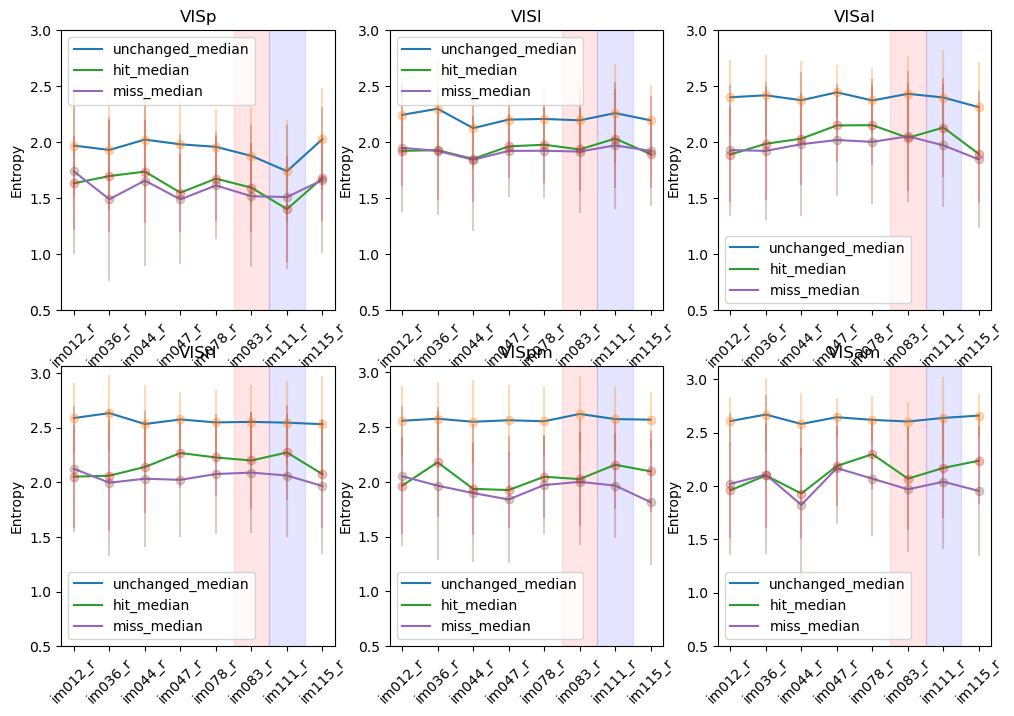

In [44]:
g_g1h2_g1_u, g_g1h2_g1_h, g_g1h2_g1_m = plot_from_file(g_g1h2_g1, 'has_first', ['u','h','m'], areas)

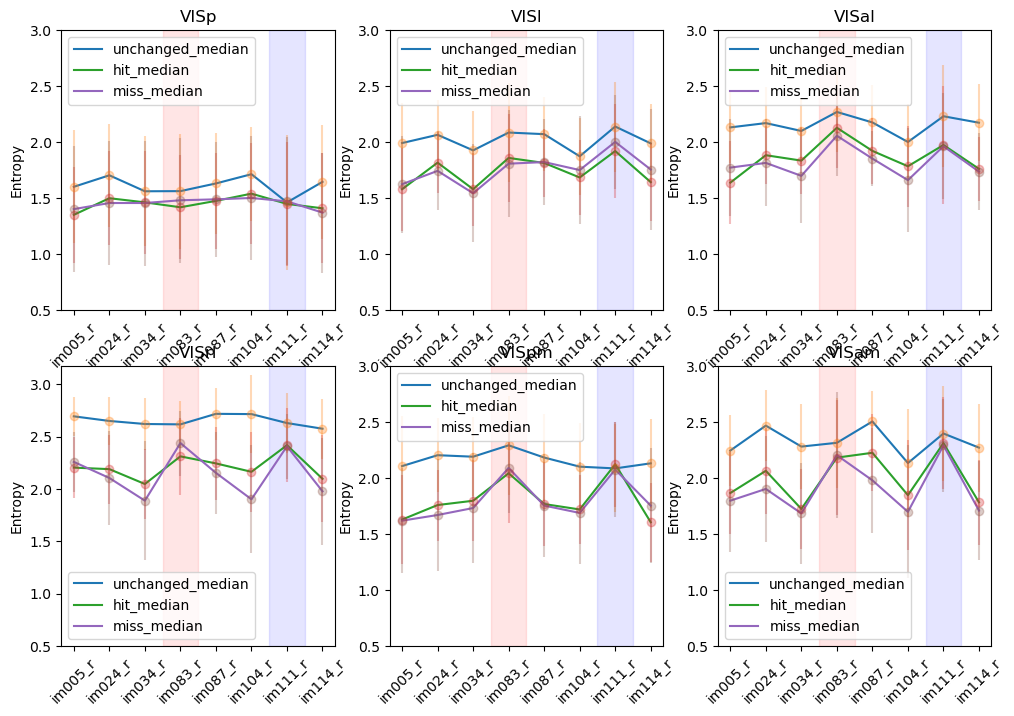

In [45]:
g_g1h2_h2_u, g_g1h2_h2_h, g_g1h2_h2_m = plot_from_file(g_g1h2_h2, 'has_first', ['u','h','m'], areas)

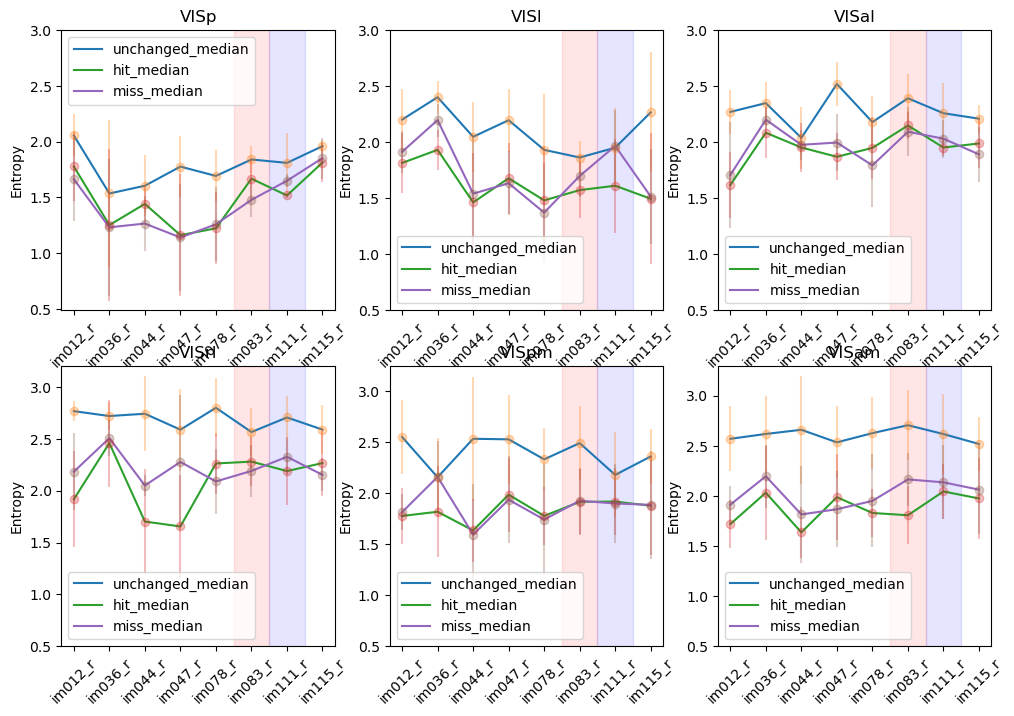

In [46]:
g_h1g2_g2_u, g_h1g2_g2_h, g_h1g2_g2_m = plot_from_file(g_h1g2_g2, 'has_first', ['u','h','m'], areas)

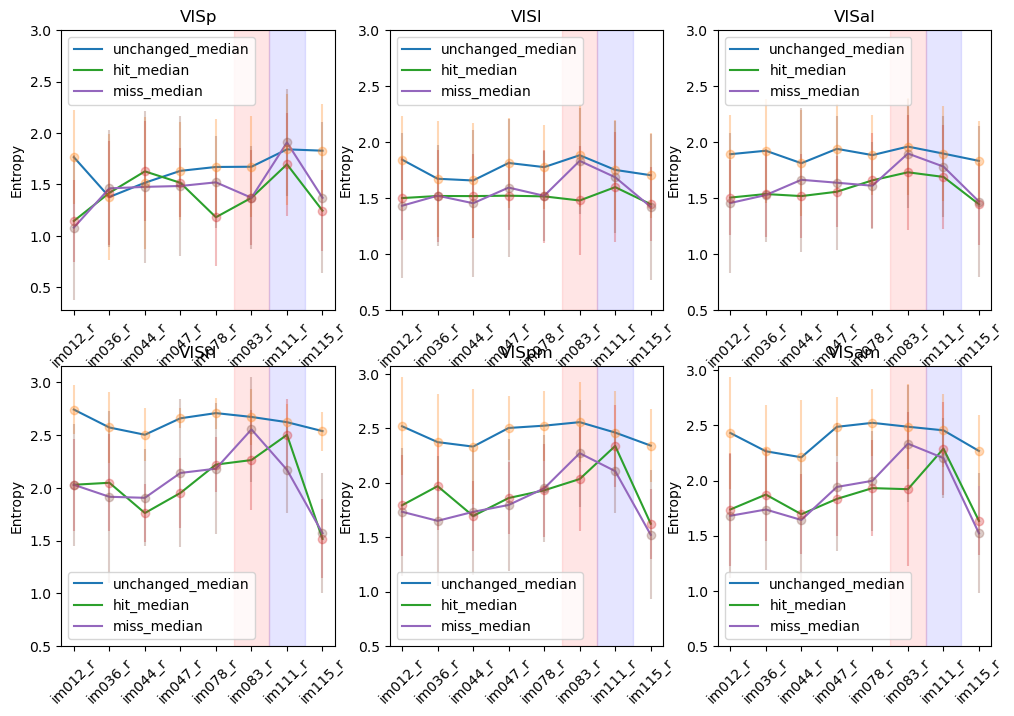

In [47]:
h_h1g2_g2_u, h_h1g2_g2_h, h_h1g2_g2_m = plot_from_file(h_h1g2_g2, 'has_first', ['u','h','m'], areas)

In [48]:
g_mask_nov = np.array([True, True, True, True, True, False, False, True, True, True])
h_mask_nov = np.array([True, True, True, False, True, True, False, True, True, True])

g_mask_share = np.logical_not(g_mask_nov)
h_mask_share = np.logical_not(h_mask_nov)

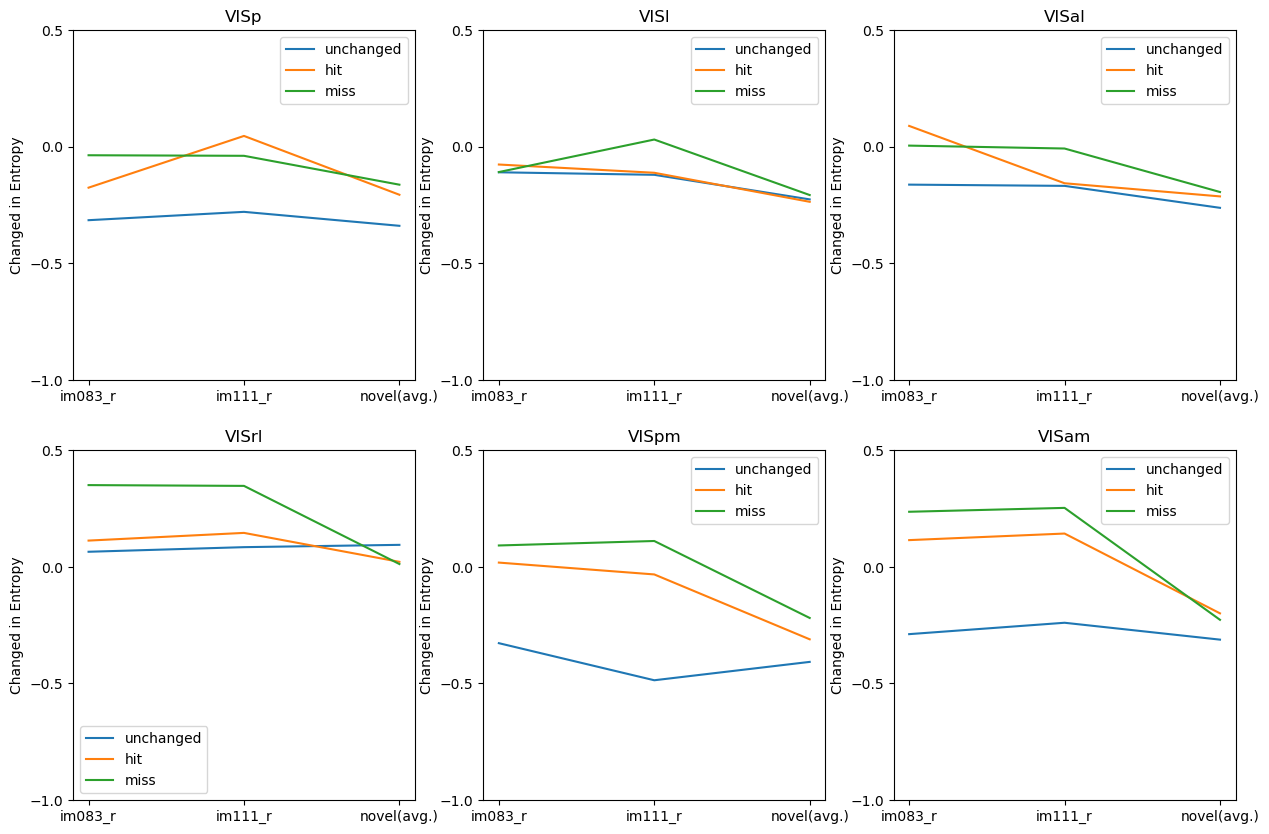

In [55]:
fig, axs = plt.subplots(2,3,figsize=(15,10))

for idx in range(6):
    diff_u_nov = g_g1h2_h2_u[idx][h_mask_nov[0:-2]] - g_g1h2_g1_u[idx][g_mask_nov[0:-2]]
    diff_h_nov = g_g1h2_h2_h[idx][h_mask_nov[0:-2]] - g_g1h2_g1_h[idx][g_mask_nov[0:-2]]
    diff_m_nov = g_g1h2_h2_m[idx][h_mask_nov[0:-2]] - g_g1h2_g1_m[idx][g_mask_nov[0:-2]]

    diff_u_share = g_g1h2_h2_u[idx][h_mask_share[0:-2]] - g_g1h2_g1_u[idx][g_mask_share[0:-2]]
    diff_h_share = g_g1h2_h2_h[idx][h_mask_share[0:-2]] - g_g1h2_g1_h[idx][g_mask_share[0:-2]]
    diff_m_share = g_g1h2_h2_m[idx][h_mask_share[0:-2]] - g_g1h2_g1_m[idx][g_mask_share[0:-2]]
    
    axs[idx//3][idx%3].plot([diff_u_share[0],diff_u_share[1],np.mean(diff_u_nov)], label  = 'unchanged')
    axs[idx//3][idx%3].plot([diff_h_share[0],diff_h_share[1],np.mean(diff_h_nov)], label  = 'hit')
    axs[idx//3][idx%3].plot([diff_m_share[0],diff_m_share[1],np.mean(diff_m_nov)], label  = 'miss')

    axs[idx//3][idx%3].set_yticks(np.arange(-1,0.6,0.5));
    axs[idx//3][idx%3].set_ylabel('Changed in Entropy');

    axs[idx//3][idx%3].set_xticks(ticks=np.arange(3), labels=['im083_r', 'im111_r', 'novel(avg.)']);
    axs[idx//3][idx%3].set_title(areas[idx])
    axs[idx//3][idx%3].legend()

In [ ]:
total_ids = g_g1h2_g1 + g_g1h2_h2 + g_h1g2_g2 + g_h1g2_h1 + h_h1g2_h1 + h_h1g2_g2
colors = generate_distinct_colors(8)

In [ ]:
fig, axs = plt.subplots(2,3,figsize=(18,12))
# Place holders
u_entropy_total = np.zeros(10) # Unchanged + omitted + gray
h_entropy_total = np.zeros(8) # Hit
m_entropy_total = np.zeros(8) # Miss
all_entropy = np.zeros(8)
all_hit_rate = np.zeros(8)

for idx, area in enumerate(areas): # ['VISp', 'VISl', 'VISal', 'VISrl', 'VISpm', 'VISam']
    for jdx, i in enumerate(g_g1h2_g1): # Trained - g, day 1 - g, day 2 - h
        # Calculated using method from alleninstitute
        rate = "C:/Users/jerry/Downloads/hit_rates/" + str(i) + ".npz"
        try:
            hit_rate_file = np.load(rate, allow_pickle=True)
            hit_rate = hit_rate_file['h_r']
        except:
            continue
        counter = 5 # If all 5 iterations are not present, then don't proceed
        for iter in range(5):
            # Files contain hidden state distribution for each image
            path = "C:/Users/jerry/Downloads/train_by_area3/has_first/" + str(area) + "/" + str(i) + "_" + str(iter) + ".npz"
            try:
                a = np.load(path, allow_pickle=True)
            except:
                counter -= 1
                continue
            # All keys: ['u', 'h', 'm', 'g', 'preds']
            # The first four are the hidden state distributions for each image
            # The last is the predicted hidden state for each time bin that was used to calculate the distributions

            #u = a['u'][0:-1] # Stimuli + omitted, excluding omitted 
            h = a['h']
            #m = a['m']
            #g = a['g']
            
            # entropy() is from scipy.stats.entropy
            # +1e-10 to avoid log(0), axis = 1 to calculate entropy for each img
            # h is structured as n_stimulus * n_hidden_states
            # Not normalized here because all cases have 8 hidden states
            #u_entropy = np.array([entropy(u+1e-10, axis=1, base=2)])
            h_entropy = np.array([entropy(h+1e-10, axis=1, base=2)])
            #m_entropy = np.array([entropy(m+1e-10, axis=1, base=2)])
            if iter == 0: # First iteration, initialize
                h_entropy_total = h_entropy
            else:
                h_entropy_total = np.vstack((h_entropy_total, h_entropy))
        if counter != 0: # At least 1 iteration is present, proceed
            #u_median = np.median(u_entropy_total, axis=0)
            h_median = np.median(h_entropy_total, axis=0) # type: ignore
            #m_median = np.median(m_entropy_total, axis=0)
            
            all_entropy= np.vstack((all_entropy, h_median)) 
            all_hit_rate = np.vstack((all_hit_rate, hit_rate))
            axs[idx//3][idx%3].scatter(h_median, hit_rate, c=colors, alpha=0.5); # Plot hit vs entropy
    # removing the placeholder
    all_entropy = np.delete(all_entropy, 0, 0)
    all_hit_rate = np.delete(all_hit_rate, 0, 0)
    # Just for the legend
    for kdx, color in enumerate(colors):
        axs[idx//3][idx%3].scatter([], [], c=color, label=imgs_g[kdx]) # imgs_g: img names for set g
    # Linear regression for each img
    for i in range(8):
        y = all_hit_rate[:, i]
        x = all_entropy[:, i]
        m, b = np.polyfit(x, y, 1)
        axs[idx//3][idx%3].plot(x, m*x+b,c=colors[i]) 

    axs[idx//3][idx%3].set_title(area)
    axs[idx//3][idx%3].set_ylabel('Hit rate');
    axs[idx//3][idx%3].set_xlabel('Entropy');
    axs[idx//3][idx%3].set_xticks(np.arange(0.5,3.1,0.5));
    axs[idx//3][idx%3].legend();

In [ ]:
fig, axs = plt.subplots(2,3,figsize=(18,12))
# Place holders
u_entropy_total = np.zeros(10) # Unchanged + omitted + gray
h_entropy_total = np.zeros(8) # Hit
m_entropy_total = np.zeros(8) # Miss
all_entropy = np.zeros(8)
all_hit_rate = np.zeros(8)

for idx, area in enumerate(areas): # ['VISp', 'VISl', 'VISal', 'VISrl', 'VISpm', 'VISam']
    for jdx, i in enumerate(g_g1h2_h2): # Trained - g, day 1 - g, day 2 - h
        # Calculated using method from alleninstitute
        rate = "C:/Users/jerry/Downloads/hit_rates/" + str(i) + ".npz"
        try:
            hit_rate_file = np.load(rate, allow_pickle=True)
            hit_rate = hit_rate_file['h_r']
        except:
            continue
        counter = 5 # If all 5 iterations are not present, then don't proceed
        for iter in range(5):
            # Files contain hidden state distribution for each image
            path = "C:/Users/jerry/Downloads/train_by_area3/has_first/" + str(area) + "/" + str(i) + "_" + str(iter) + ".npz"
            try:
                a = np.load(path, allow_pickle=True)
            except:
                counter -= 1
                continue
            #u = a['u'][0:-1] # Stimuli + omitted, excluding omitted 
            h = a['h']
            #m = a['m']
            #g = a['g']
            
            # scipy.stats.entropy
            # +1e-10 to avoid log(0), axis = 1 to calculate entropy for each img
            # h is structured as n_stimulus * n_hidden_states
            # Not normalized here because all cases have 8 hidden states
            #u_entropy = np.array([entropy(u+1e-10, axis=1, base=2)])
            h_entropy = np.array([entropy(h+1e-10, axis=1, base=2)])
            #m_entropy = np.array([entropy(m+1e-10, axis=1, base=2)])
            if iter == 0: # First iteration, initialize
                h_entropy_total = h_entropy
            else:
                h_entropy_total = np.vstack((h_entropy_total, h_entropy))
        if counter != 0: # At least 1 iteration is present, proceed
            #u_median = np.median(u_entropy_total, axis=0)
            h_median = np.median(h_entropy_total, axis=0) # type: ignore
            #m_median = np.median(m_entropy_total, axis=0)
            
            all_entropy= np.vstack((all_entropy, h_median)) 
            all_hit_rate = np.vstack((all_hit_rate, hit_rate))
            axs[idx//3][idx%3].scatter(h_median, hit_rate, c=colors, alpha=0.5); # Plot hit vs entropy
    # removing the placeholder
    all_entropy = np.delete(all_entropy, 0, 0)
    all_hit_rate = np.delete(all_hit_rate, 0, 0)
    # Just for the legend
    for kdx, color in enumerate(colors):
        axs[idx//3][idx%3].scatter([], [], c=color, label=imgs_h[kdx])# imgs_h: img names for set h
    # Linear regression for each img
    for i in range(8):
        y = all_hit_rate[:, i]
        x = all_entropy[:, i]
        m, b = np.polyfit(x, y, 1)
        axs[idx//3][idx%3].plot(x, m*x+b,c=colors[i]) 

    axs[idx//3][idx%3].set_title(area)
    axs[idx//3][idx%3].set_ylabel('Hit rate');
    axs[idx//3][idx%3].set_xlabel('Entropy');
    axs[idx//3][idx%3].set_xticks(np.arange(0.5,3.1,0.5));
    axs[idx//3][idx%3].legend();

#### Data from train_by_area_250

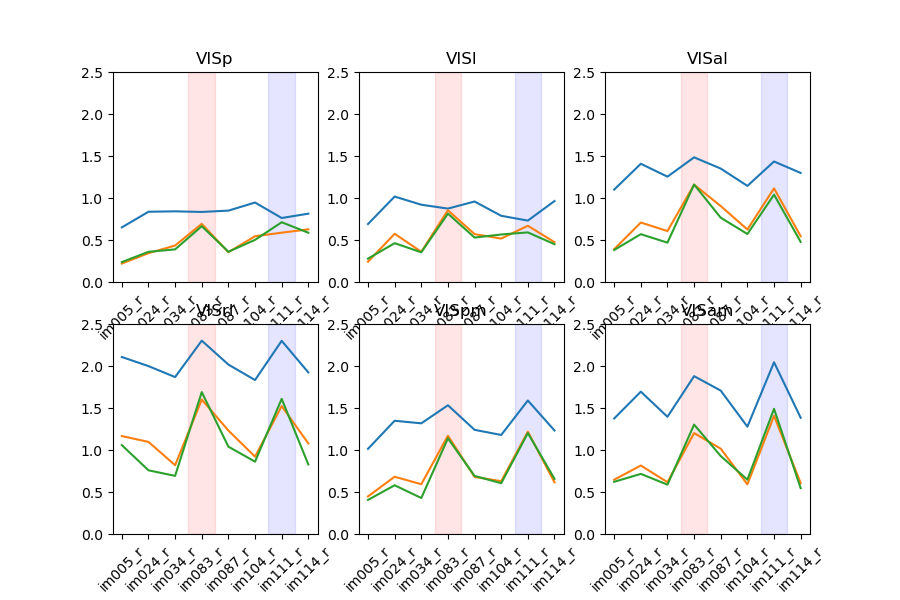

In [114]:
ids = g_g1h2_h2
u_entropy_total = np.zeros(8)
h_entropy_total = np.zeros(8)
m_entropy_total = np.zeros(8)
fig, axs = plt.subplots(2,3,figsize=(9,6))
for idx, area in enumerate(areas):
    counter = 0
    u_entropy_total = np.zeros(8)
    h_entropy_total = np.zeros(8)
    m_entropy_total = np.zeros(8)
    for i in ids:
        for iter in range(5):
            path = "C:/Users/jerry/Downloads/train_by_area_250/" + str(area) + "/" + str(i) + "_" + str(iter) + ".npz"
            try:
                a = np.load(path, allow_pickle=True)
            except:
                continue
            u = a['u'][0:-1]
            h = a['h']
            m = a['m']
            g = a['g']
            u_entropy_total += entropy(u+1e-10, axis=1,base=2)
            h_entropy_total += entropy(h+1e-10, axis=1,base=2)
            m_entropy_total += entropy(m+1e-10, axis=1,base=2)
            counter += 1
    u_entropy_total = u_entropy_total / counter
    h_entropy_total = h_entropy_total / counter
    m_entropy_total = m_entropy_total / counter
    axs[idx//3][idx%3].plot(u_entropy_total, label  = 'unchanged')
    axs[idx//3][idx%3].plot(h_entropy_total, label  = 'hit')
    axs[idx//3][idx%3].plot(m_entropy_total, label  = 'miss')
    axs[idx//3][idx%3].axvspan(2.5,3.5,alpha=0.1,color='red')
    axs[idx//3][idx%3].axvspan(5.5,6.5,alpha=0.1,color='blue')
    axs[idx//3][idx%3].set_title(area)
    axs[idx//3][idx%3].set_yticks(np.arange(0.,2.6,0.5));
    axs[idx//3][idx%3].set_xticks(ticks = np.arange(0,8), labels = imgs_h[:-2], rotation=45);

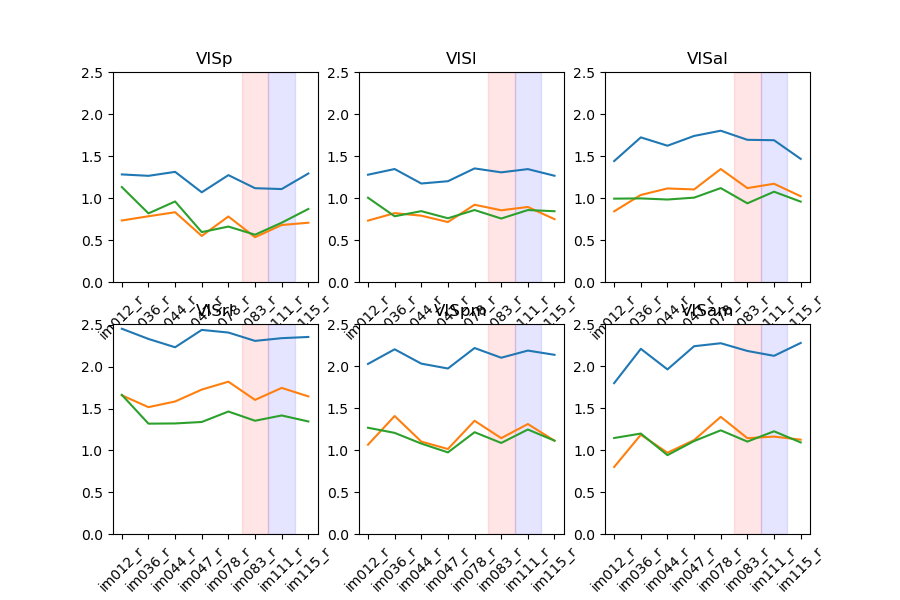

In [115]:
ids = g_g1h2_g1
u_entropy_total = np.zeros(8)
h_entropy_total = np.zeros(8)
m_entropy_total = np.zeros(8)
fig, axs = plt.subplots(2,3,figsize=(9,6))
for idx, area in enumerate(areas):
    counter = 0
    u_entropy_total = np.zeros(8)
    h_entropy_total = np.zeros(8)
    m_entropy_total = np.zeros(8)
    for i in ids:
        for iter in range(5):
            path = "C:/Users/jerry/Downloads/train_by_area_250/" + str(area) + "/" + str(i) + "_" + str(iter) + ".npz"
            try:
                a = np.load(path, allow_pickle=True)
            except:
                continue
            u = a['u'][0:-1]
            h = a['h']
            m = a['m']
            g = a['g']
            u_entropy_total += entropy(u+1e-10, axis=1,base=2)
            h_entropy_total += entropy(h+1e-10, axis=1,base=2)
            m_entropy_total += entropy(m+1e-10, axis=1,base=2)
            counter += 1
    u_entropy_total = u_entropy_total / counter
    h_entropy_total = h_entropy_total / counter
    m_entropy_total = m_entropy_total / counter
    axs[idx//3][idx%3].plot(u_entropy_total, label  = 'unchanged')
    axs[idx//3][idx%3].plot(h_entropy_total, label  = 'hit')
    axs[idx//3][idx%3].plot(m_entropy_total, label  = 'miss')
    axs[idx//3][idx%3].axvspan(4.5,5.5,alpha=0.1,color='red')
    axs[idx//3][idx%3].axvspan(5.5,6.5,alpha=0.1,color='blue')
    axs[idx//3][idx%3].set_title(area)
    axs[idx//3][idx%3].set_yticks(np.arange(0.,2.6,0.5));
    axs[idx//3][idx%3].set_xticks(ticks = np.arange(0,8), labels = imgs_g[:-2], rotation=45);

C:\Users\jerry\AppData\Local\Temp\ipykernel_10984\2318204375.py:149: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  c = plt.cm.get_cmap('turbo', n)


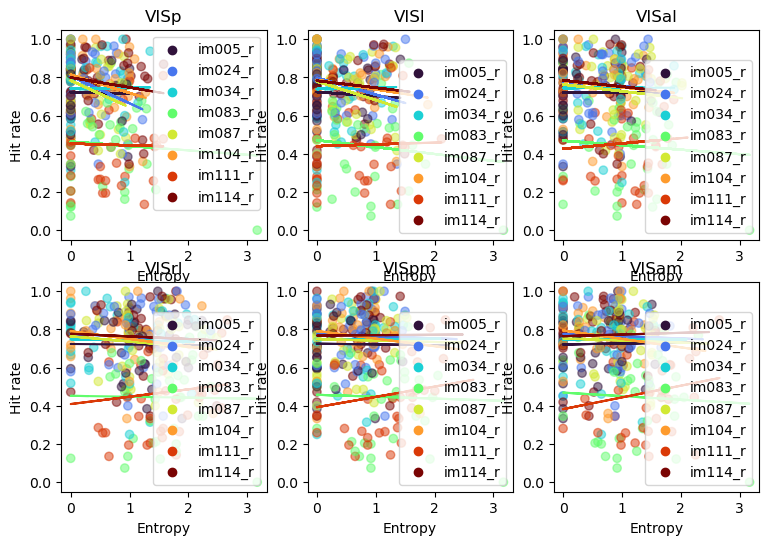

In [6]:
colors = generate_distinct_colors(8)
fig, axs = plt.subplots(2,3,figsize=(9,6))
h_entropy_total = np.zeros(8)
all_entropy = np.zeros(8)
all_hit_rate = np.zeros(8)

for idx, area in enumerate(areas):
    for jdx, i in enumerate(g_g1h2_h2):
        rate = "C:/Users/jerry/Downloads/hit_rates/" + str(i) + ".npz"
        try:
            hit_rate_file = np.load(rate, allow_pickle=True)
            hit_rate = hit_rate_file['h_r']
        except:
            continue
        for iter in range(5):
            path = "C:/Users/jerry/Downloads/train_by_area_250/" + str(area) + "/" + str(i) + "_" + str(iter) + ".npz"
            try:
                a = np.load(path, allow_pickle=True)
            except:
                break            
            h = a['h']
            h_entropy = np.array([entropy(h+1e-10, axis=1, base=2)])
            if iter == 0:
                h_entropy_total = h_entropy
            else:
                h_entropy_total = np.vstack((h_entropy_total, h_entropy))
        h_median = np.median(h_entropy_total, axis=0) # type: ignore
        
        all_entropy= np.vstack((all_entropy, h_median)) 
        all_hit_rate = np.vstack((all_hit_rate, hit_rate))
        
        axs[idx//3][idx%3].scatter(h_median, hit_rate, c=colors, alpha=0.5);
    
    all_entropy = np.delete(all_entropy, 0, 0)
    all_hit_rate = np.delete(all_hit_rate, 0, 0)
    for kdx, color in enumerate(colors):
        axs[idx//3][idx%3].scatter([], [], color=color, label=imgs_h[kdx])
    
    for i in range(8):
        y = all_hit_rate[:, i]
        x = all_entropy[:, i]
        m, b = np.polyfit(x, y, 1)
        axs[idx//3][idx%3].plot(x, m*x+b,color=colors[i]) 

    axs[idx//3][idx%3].set_title(area)
    axs[idx//3][idx%3].set_ylabel('Hit rate');
    axs[idx//3][idx%3].set_xlabel('Entropy');
#    axs[idx//3][idx%3].set_xticks(np.arange(0.5,3.1,0.5));
    axs[idx//3][idx%3].legend();

In [13]:
colors = ['red', 'green','blue','yellow','pink','purple','orange','brown','cyan','teal']

##### Day 1

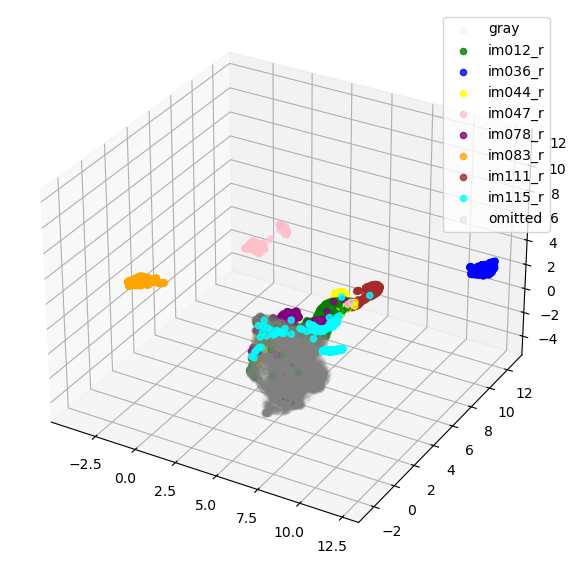

In [10]:
unit_idx = unit_channels_filtered[unit_channels_filtered['structure_acronym'] == 'VISp'].index
X, N = get_X(sp, spike_times, unit_idx, 250)
model_umap = umap.UMAP(n_neighbors=20, min_dist=0.1, spread=1, n_components=3, metric='euclidean')
X_umap = model_umap.fit_transform(X)
fig = plt.figure(figsize=(24,8))
gs = fig.add_gridspec(1, 3)
ax = fig.add_subplot(gs[0,0], projection='3d')
unique_stim = np.unique(N)
for i, stim in enumerate(unique_stim):
    idx = np.where(N == stim)[0]
    if stim == 'gray':
        ax.scatter(X_umap[idx,0], X_umap[idx,1], X_umap[idx,2], color='gray', label=stim, alpha=0.05) # type: ignore
    elif stim == 'omitted':
        #continue
        ax.scatter(X_umap[idx,0], X_umap[idx,1], X_umap[idx,2], color='black', label=stim, alpha=0.05) # type: ignore
    else:
        ax.scatter(X_umap[idx,0], X_umap[idx,1], X_umap[idx,2], color=colors[i], label=stim, alpha=0.8) # type: ignore
ax.legend();

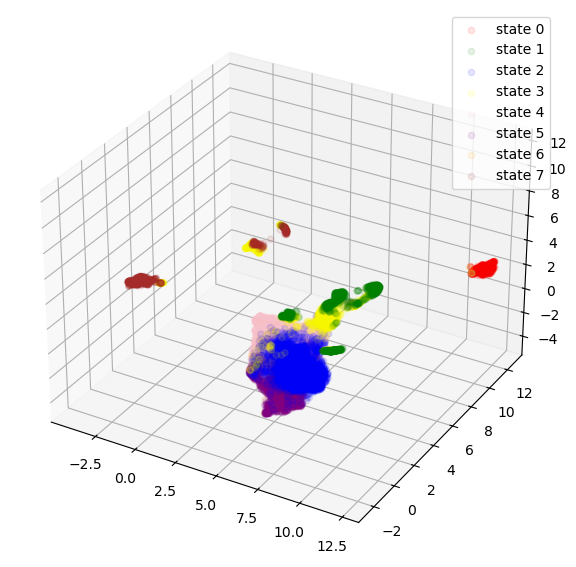

In [11]:
model = hmm.PoissonHMM(n_components=8, verbose=False, n_iter=1000, tol=1)
model.fit(X)
pred = model.predict(X)
unique_preds = np.unique(pred)
fig = plt.figure(figsize=(24,8))
gs = fig.add_gridspec(1, 3)
ax = fig.add_subplot(gs[0,0], projection='3d')
for i, p in enumerate(unique_preds):
    idx = np.where(pred == p)[0]
    color = colors[i]
    label='state ' + str(p)
    ax.scatter(X_umap[idx,0], X_umap[idx,1], X_umap[idx,2], color=color, label=label, alpha=0.1)
ax.legend();

##### Day 2

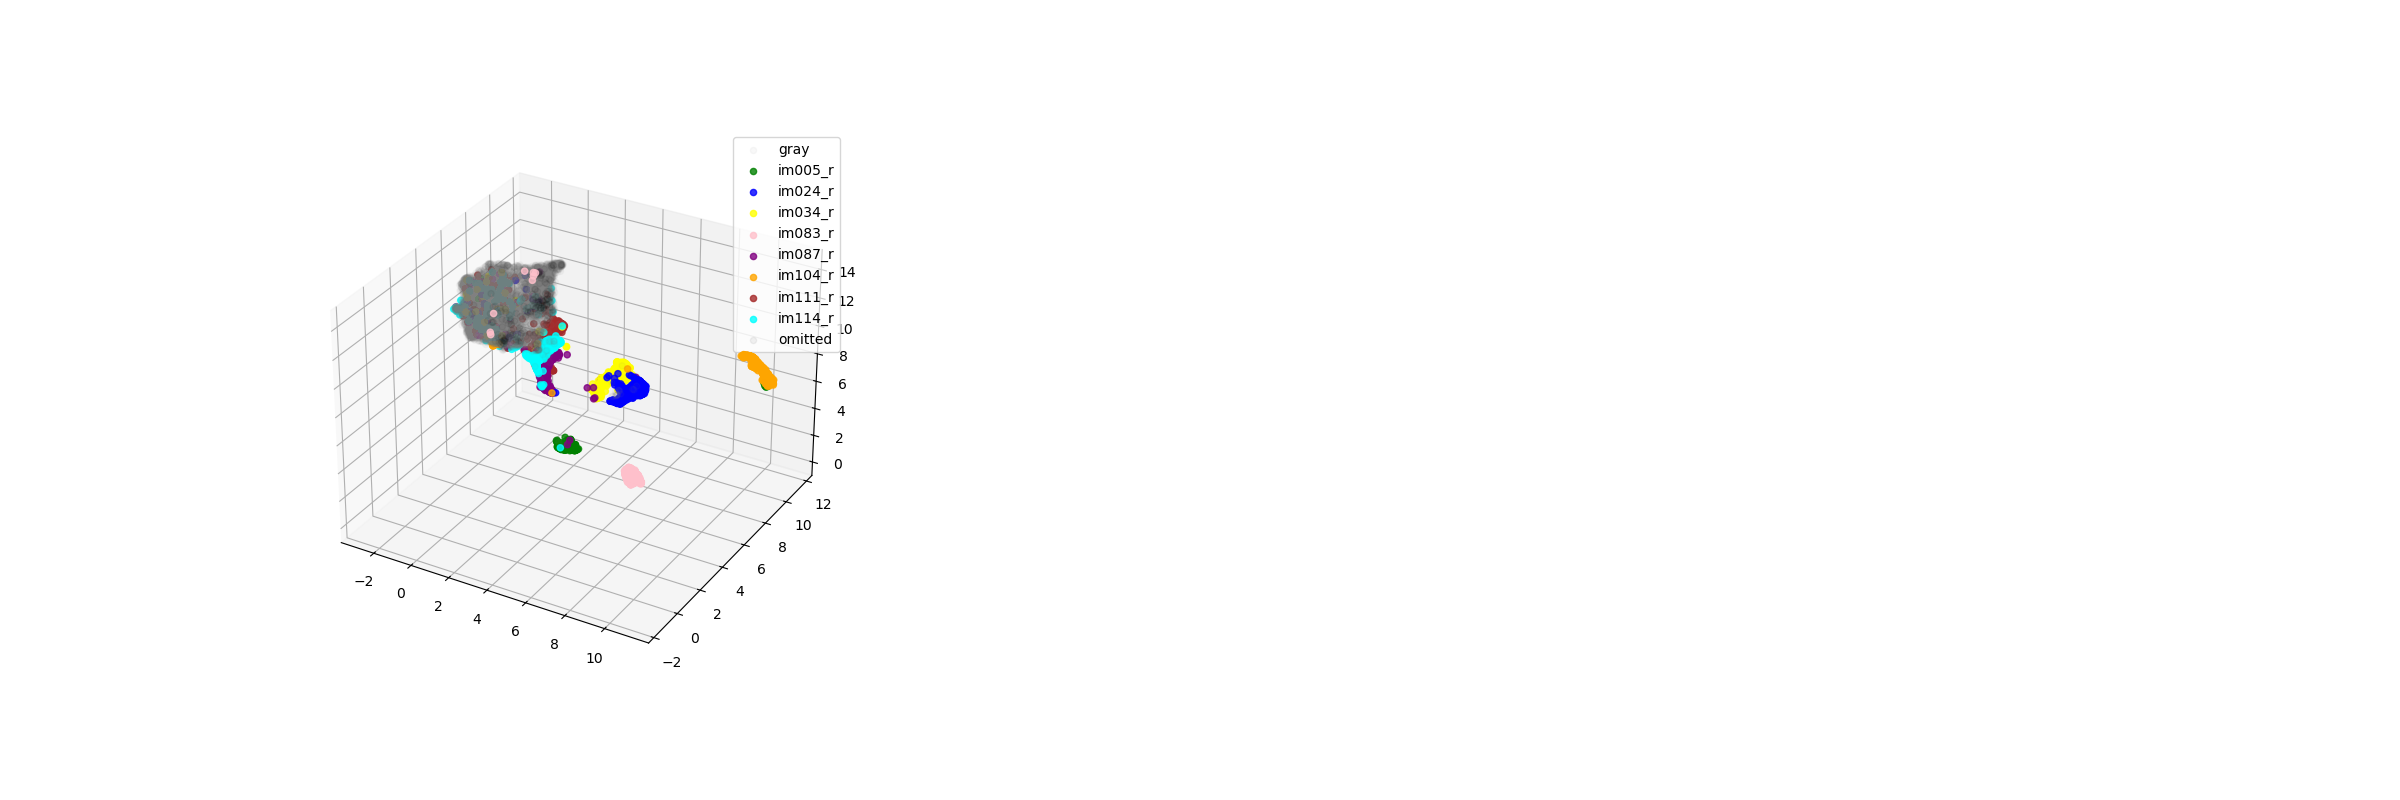

In [97]:
unit_idx = unit_channels_filtered[unit_channels_filtered['structure_acronym'] == 'VISp'].index
X, N = get_X(sp, spike_times, unit_idx, 250)
X_umap = umap.UMAP(n_neighbors=20, min_dist=0.1, spread=1, n_components=3, metric='euclidean').fit_transform(X)
fig = plt.figure(figsize=(24,8))
gs = fig.add_gridspec(1, 3)
ax = fig.add_subplot(gs[0,0], projection='3d')
unique_stim = np.unique(N)
for i, stim in enumerate(unique_stim):
    idx = np.where(N == stim)[0]
    if stim == 'gray':
        ax.scatter(X_umap[idx,0], X_umap[idx,1], X_umap[idx,2], color='gray', label=stim, alpha=0.05) # type: ignore
    elif stim == 'omitted':
        #continue
        ax.scatter(X_umap[idx,0], X_umap[idx,1], X_umap[idx,2], color='black', label=stim, alpha=0.05) # type: ignore
    else:
        ax.scatter(X_umap[idx,0], X_umap[idx,1], X_umap[idx,2], color=colors[i], label=stim, alpha=0.8) # type: ignore
ax.legend();

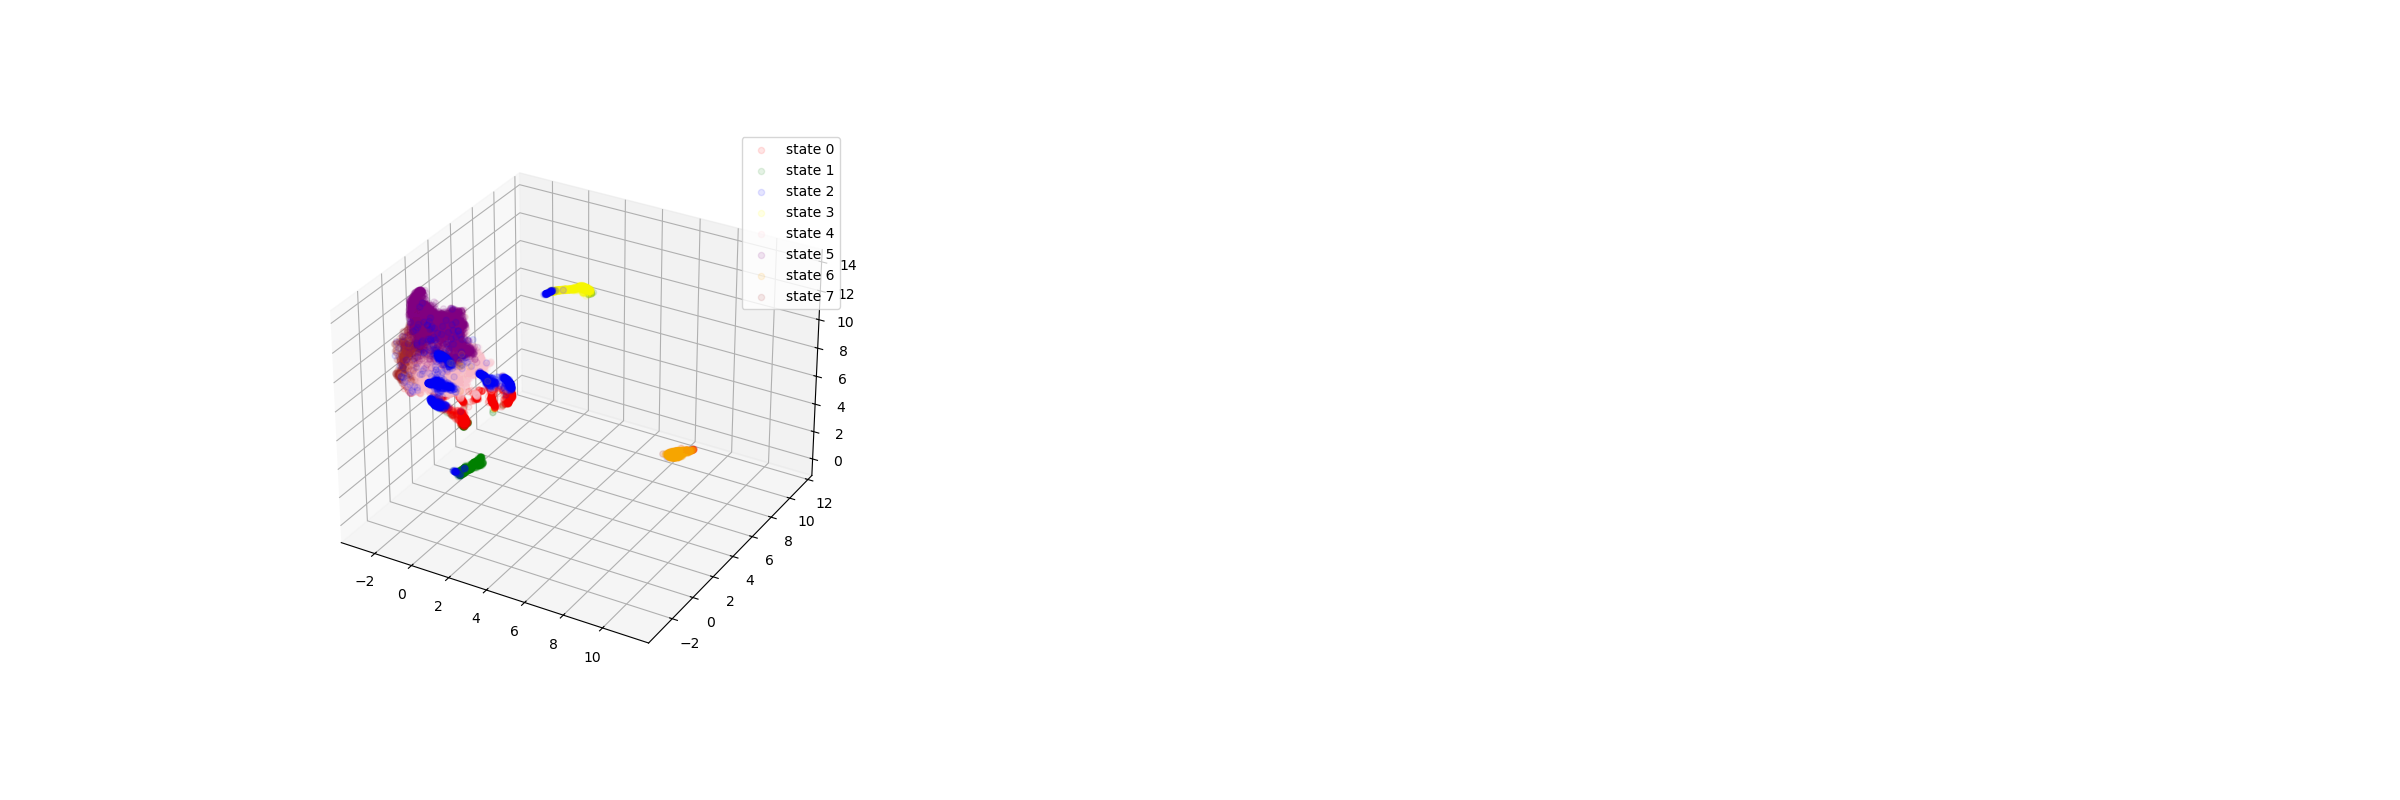

In [89]:
model = hmm.PoissonHMM(n_components=8, verbose=False, n_iter=1000, tol=1)
model.fit(X)
pred = model.predict(X)
unique_preds = np.unique(pred)
fig = plt.figure(figsize=(24,8))
gs = fig.add_gridspec(1, 3)
ax = fig.add_subplot(gs[0,0], projection='3d')
for i, p in enumerate(unique_preds):
    idx = np.where(pred == p)[0]
    color = colors[i]
    label='state ' + str(p)
    ax.scatter(X_umap[idx,0], X_umap[idx,1], X_umap[idx,2], color=color, label=label, alpha=0.1)
ax.legend();

#### Data from train_by_area_250, again :)

In [47]:
def testing(ids, areas):
    u_entropy_total = np.zeros(8)
    h_entropy_total = np.zeros(8)
    m_entropy_total = np.zeros(8)
    dict = {}
    for idx, area in enumerate(areas):
        for jdx, i in enumerate(ids):
            for iter in range(5):
                path = "C:/Users/jerry/Downloads/train_by_area_250/" + str(area) + "/" + str(i) + "_" + str(iter) + ".npz"
                try:
                    a = np.load(path, allow_pickle=True)
                except:
                    continue
                u = a['u'][:-1]
                h = a['h']
                m = a['m']
                u_entropy = np.array([entropy(u+1e-10, axis=1,base=2)])
                h_entropy = np.array([entropy(h+1e-10, axis=1,base=2)])
                m_entropy = np.array([entropy(m+1e-10, axis=1,base=2)])
                if (iter == 0) and (jdx == 0): # initialize
                    u_entropy_total = u_entropy
                    h_entropy_total = h_entropy
                    m_entropy_total = m_entropy
                else:
                    u_entropy_total = np.vstack((u_entropy_total, u_entropy))
                    h_entropy_total = np.vstack((h_entropy_total, h_entropy))
                    m_entropy_total = np.vstack((m_entropy_total, m_entropy))

    return dict

In [78]:
def testing0(ids, areas):
    u_entropy_total = np.zeros(8)
    h_entropy_total = np.zeros(8)
    m_entropy_total = np.zeros(8)
    dict = {}
    for idx, area in enumerate(areas):
        for jdx, i in enumerate(ids):
            for iter in range(5):
                path = "C:/Users/jerry/Downloads/train_by_area3/has_first/" + str(area) + "/" + str(i) + "_" + str(iter) + ".npz"
                try:
                    a = np.load(path, allow_pickle=True)
                except:
                    continue
                u = a['u'][:-1]
                h = a['h']
                m = a['m']
                u_entropy = np.array([entropy(u+1e-10, axis=1,base=2)])
                h_entropy = np.array([entropy(h+1e-10, axis=1,base=2)])
                m_entropy = np.array([entropy(m+1e-10, axis=1,base=2)])
                if (iter == 0) and (jdx == 0) and (idx == 0): # initialize
                    u_entropy_total = u_entropy
                    h_entropy_total = h_entropy
                    m_entropy_total = m_entropy
                else:
                    u_entropy_total = np.vstack((u_entropy_total, u_entropy))
                    h_entropy_total = np.vstack((h_entropy_total, h_entropy))
                    m_entropy_total = np.vstack((m_entropy_total, m_entropy))
    u_median = np.median(u_entropy_total, axis=0) # type: ignore
    h_median = np.median(h_entropy_total, axis=0) # type: ignore
    m_median = np.median(m_entropy_total, axis=0) # type: ignore
    std_u = np.std(u_entropy_total, axis=0) # type: ignore
    std_h = np.std(h_entropy_total, axis=0) # type: ignore
    std_m = np.std(m_entropy_total, axis=0) # type: ignore
    return [u_median, h_median, m_median, std_u, std_h, std_m]

In [61]:
g_familiar = np.array([True, True, True, True, True, False, False, True])
g_shared = np.logical_not(g_familiar)

h_novel = np.array([True, True, True, False, True, True, False, True])
h_shared = np.logical_not(h_novel)

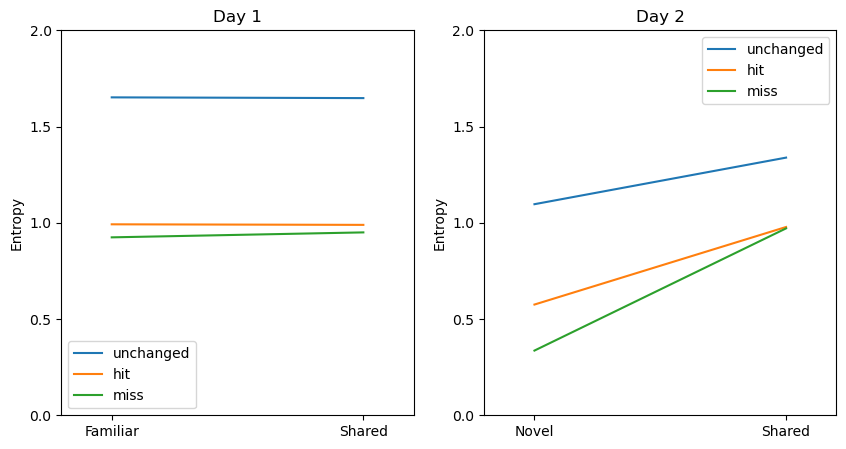

In [75]:
fig, axs = plt.subplots(1,2,figsize=(10,5))
u_median, h_median, m_median, std_u, std_h, std_m = testing0(g_g1h2_g1, areas)
axs[0].plot([np.mean(u_median[g_familiar]), np.mean(u_median[g_shared])], label  = 'unchanged')
axs[0].plot([np.mean(h_median[g_familiar]), np.mean(h_median[g_shared])], label  = 'hit')
axs[0].plot([np.mean(m_median[g_familiar]), np.mean(m_median[g_shared])], label  = 'miss')
axs[0].set_ylabel('Entropy');
axs[0].set_yticks(np.arange(0,2.1,0.5));
axs[0].set_title('Day 1')
axs[0].set_xticks(ticks = np.arange(2), labels = ['Familiar', 'Shared']);
axs[0].set_xlim(-0.2,1.2);
axs[0].legend();

u_median, h_median, m_median, std_u, std_h, std_m = testing0(g_g1h2_h2, areas)
axs[1].plot([np.mean(u_median[h_novel]), np.mean(u_median[h_shared])], label  = 'unchanged')
axs[1].plot([np.mean(h_median[h_novel]), np.mean(h_median[h_shared])], label  = 'hit')
axs[1].plot([np.mean(m_median[h_novel]), np.mean(m_median[h_shared])], label  = 'miss')
axs[1].set_ylabel('Entropy');
axs[1].set_yticks(np.arange(0,2.1,0.5));
axs[1].set_title('Day 2')
axs[1].set_xticks(ticks = np.arange(2), labels = ['Novel', 'Shared']);
axs[1].set_xlim(-0.2,1.2);
axs[1].legend();

In [48]:
hierarchy = ['VISp', 'VISl', 'VISrl', 'VISal', 'VISpm', 'VISam']
dict_1 = testing(g_g1h2_g1, hierarchy)
dict_2 = testing(g_g1h2_h2, hierarchy)

##### Day 1

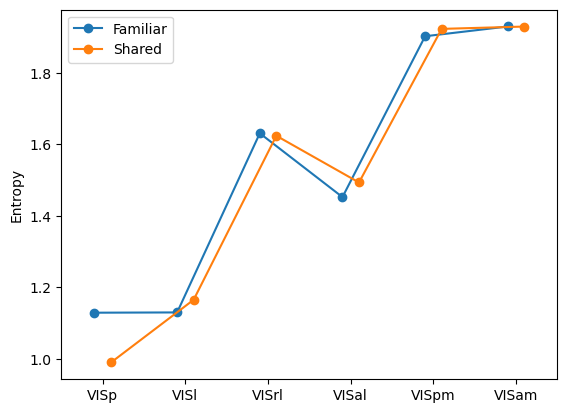

In [56]:
u_fam_1 = np.zeros(len(hierarchy))
u_shr_1 = np.zeros(len(hierarchy))

major_ticks = np.arange(1, 11.1, 2)
minor_1 = np.arange(0.8, 10.9, 2)
minor_2 = np.arange(1.2, 11.3, 2)
minor_ticks = np.sort(np.concatenate((minor_1, minor_2)))
#entropy_2 = np.zeros(len(hierarchy))

for idx, area in enumerate(hierarchy):
    u_fam_1[idx] = np.mean(np.mean(dict_1[area][0][:, g_familiar]))
    #print(np.mean(np.mean(u_fam_1)))
    u_shr_1[idx] = np.mean(np.mean(dict_1[area][0][:, g_shared]))
    #print(np.mean(np.mean(u_shr_1)))
#    u_nov_2 = dict_2[area][0][:, h_novel]
#    u_shr_2 = dict_2[area][0][:, h_shared]
#    entropy_1[idx] = np.mean(u_fam_1) - np.mean(u_shr_1)
plt.xlim(0,12)
plt.xticks(ticks=major_ticks, labels=hierarchy);
plt.plot(minor_1, u_fam_1, label='Familiar', marker='o')
plt.plot(minor_2, u_shr_1, label='Shared', marker='o')
plt.legend();
plt.ylabel('Entropy');

##### Day 2

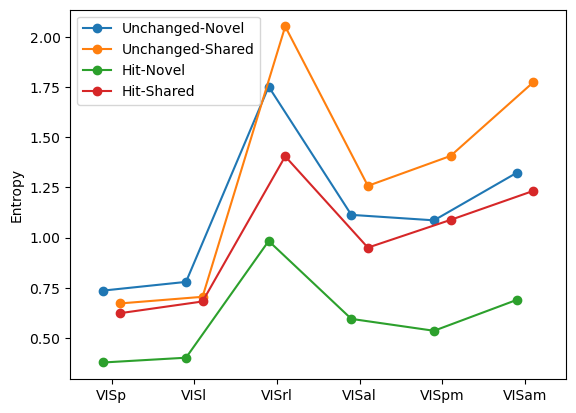

In [86]:
u_nvl_2 = np.zeros(len(hierarchy))
u_shr_2 = np.zeros(len(hierarchy))
h_nvl_2 = np.zeros(len(hierarchy))
h_shr_2 = np.zeros(len(hierarchy))
major_ticks = np.arange(1, 11.1, 2)
minor_1 = np.arange(0.8, 10.9, 2)
minor_2 = np.arange(1.2, 11.3, 2)
minor_ticks = np.sort(np.concatenate((minor_1, minor_2)))
#entropy_2 = np.zeros(len(hierarchy))

for idx, area in enumerate(hierarchy):
    u_nvl_2[idx] = np.mean(np.mean(dict_2[area][0][:, h_novel]))
    u_shr_2[idx] = np.mean(np.mean(dict_2[area][0][:, h_shared]))
    h_nvl_2[idx] = np.mean(np.mean(dict_2[area][1][:, h_novel]))
    h_shr_2[idx] = np.mean(np.mean(dict_2[area][1][:, h_shared]))
plt.xlim(0,12)
plt.xticks(ticks=major_ticks, labels=hierarchy);
#plt.xticks(ticks=minor_ticks, labels=['1','2']*6, minor=True);
plt.plot(minor_1, u_nvl_2, label='Unchanged-Novel', marker='o')
plt.plot(minor_2, u_shr_2, label='Unchanged-Shared', marker='o')
plt.plot(minor_1, h_nvl_2, label='Hit-Novel', marker='o')
plt.plot(minor_2, h_shr_2, label='Hit-Shared', marker='o')
plt.legend();
plt.ylabel('Entropy');

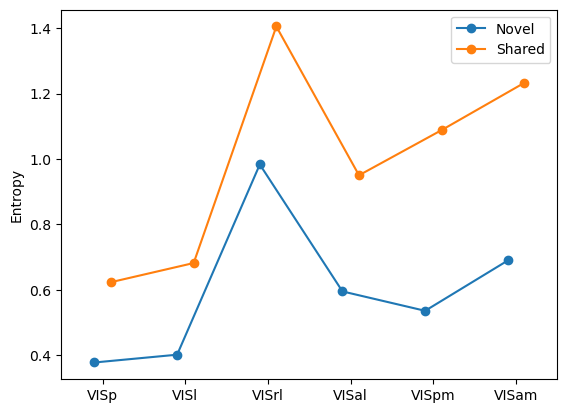

In [64]:
h_nvl_2 = np.zeros(len(hierarchy))
h_shr_2 = np.zeros(len(hierarchy))
major_ticks = np.arange(1, 11.1, 2)
minor_1 = np.arange(0.8, 10.9, 2)
minor_2 = np.arange(1.2, 11.3, 2)
minor_ticks = np.sort(np.concatenate((minor_1, minor_2)))
#entropy_2 = np.zeros(len(hierarchy))

for idx, area in enumerate(hierarchy):
    h_nvl_2[idx] = np.mean(np.mean(dict_2[area][1][:, h_novel]))
    h_shr_2[idx] = np.mean(np.mean(dict_2[area][1][:, h_shared]))
plt.xlim(0,12)
plt.xticks(ticks=major_ticks, labels=hierarchy);
plt.plot(minor_1, h_nvl_2, label='Novel', marker='o')
plt.plot(minor_2, h_shr_2, label='Shared', marker='o')
plt.legend();
plt.ylabel('Entropy');

In [45]:
def testing(ids, areas):
    u_entropy_total = np.zeros(8)
    h_entropy_total = np.zeros(8)
    m_entropy_total = np.zeros(8)
    dict = {}
    for idx, area in enumerate(areas):
        for jdx, i in enumerate(ids):
            for iter in range(5):
                path = "C:/Users/jerry/Downloads/train_by_area_250/" + str(area) + "/" + str(i) + "_" + str(iter) + ".npz"
                try:
                    a = np.load(path, allow_pickle=True)
                except:
                    continue
                u = a['u'][:-1]
                h = a['h']
                m = a['m']
                u_entropy = np.array([entropy(u+1e-10, axis=1,base=2)])
                h_entropy = np.array([entropy(h+1e-10, axis=1,base=2)])
                m_entropy = np.array([entropy(m+1e-10, axis=1,base=2)])
                if (iter == 0) and (jdx == 0): # initialize
                    u_entropy_total = u_entropy
                    h_entropy_total = h_entropy
                    m_entropy_total = m_entropy
                else:
                    u_entropy_total = np.vstack((u_entropy_total, u_entropy))
                    h_entropy_total = np.vstack((h_entropy_total, h_entropy))
                    m_entropy_total = np.vstack((m_entropy_total, m_entropy))
        dict[area] = [u_entropy_total, h_entropy_total, m_entropy_total]
    return dict

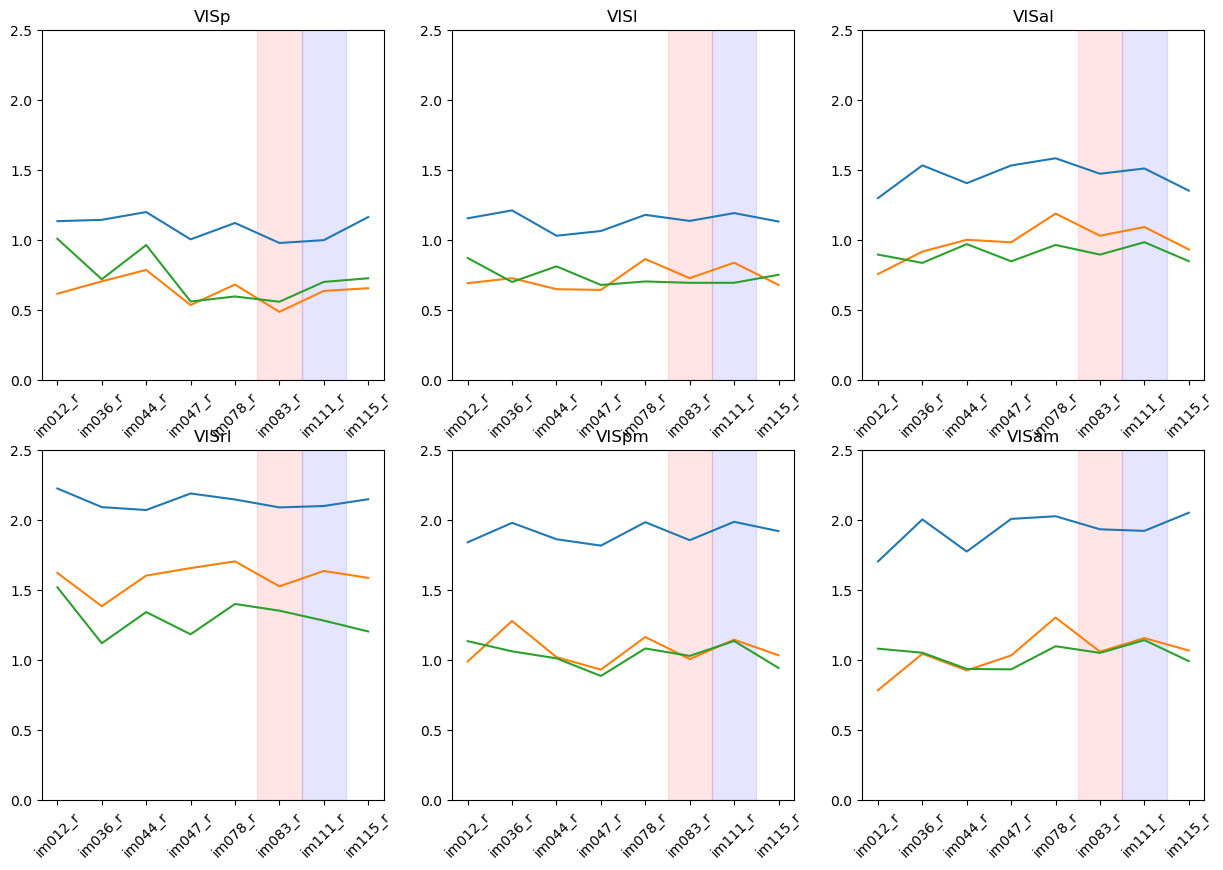

In [40]:
ids = g_g1h2_g1
u_entropy_total = np.zeros(8)
h_entropy_total = np.zeros(8)
m_entropy_total = np.zeros(8)
fig, axs = plt.subplots(2,3,figsize=(15,10))
for idx, area in enumerate(areas):
    counter = 0
    u_entropy_total = np.zeros(8)
    h_entropy_total = np.zeros(8)
    m_entropy_total = np.zeros(8)
    for i in ids:
        for iter in range(5):
            path = "C:/Users/jerry/Downloads/train_by_area_250/" + str(area) + "/" + str(i) + "_" + str(iter) + ".npz"
            try:
                a = np.load(path, allow_pickle=True)
            except:
                continue
            u = a['u'][0:-1]
            h = a['h']
            m = a['m']
            g = a['g']
            u_entropy_total += entropy(u+1e-10, axis=1,base=2)
            h_entropy_total += entropy(h+1e-10, axis=1,base=2)
            m_entropy_total += entropy(m+1e-10, axis=1,base=2)
            counter += 1
    u_entropy_total = u_entropy_total / counter
    h_entropy_total = h_entropy_total / counter
    m_entropy_total = m_entropy_total / counter
    axs[idx//3][idx%3].plot(u_entropy_total, label  = 'unchanged')
    axs[idx//3][idx%3].plot(h_entropy_total, label  = 'hit')
    axs[idx//3][idx%3].plot(m_entropy_total, label  = 'miss')
    axs[idx//3][idx%3].axvspan(4.5,5.5,alpha=0.1,color='red')
    axs[idx//3][idx%3].axvspan(5.5,6.5,alpha=0.1,color='blue')
    axs[idx//3][idx%3].set_title(area)
    axs[idx//3][idx%3].set_yticks(np.arange(0.,2.6,0.5));
    axs[idx//3][idx%3].set_xticks(ticks = np.arange(0,8), labels = imgs_g[:-2], rotation=45);

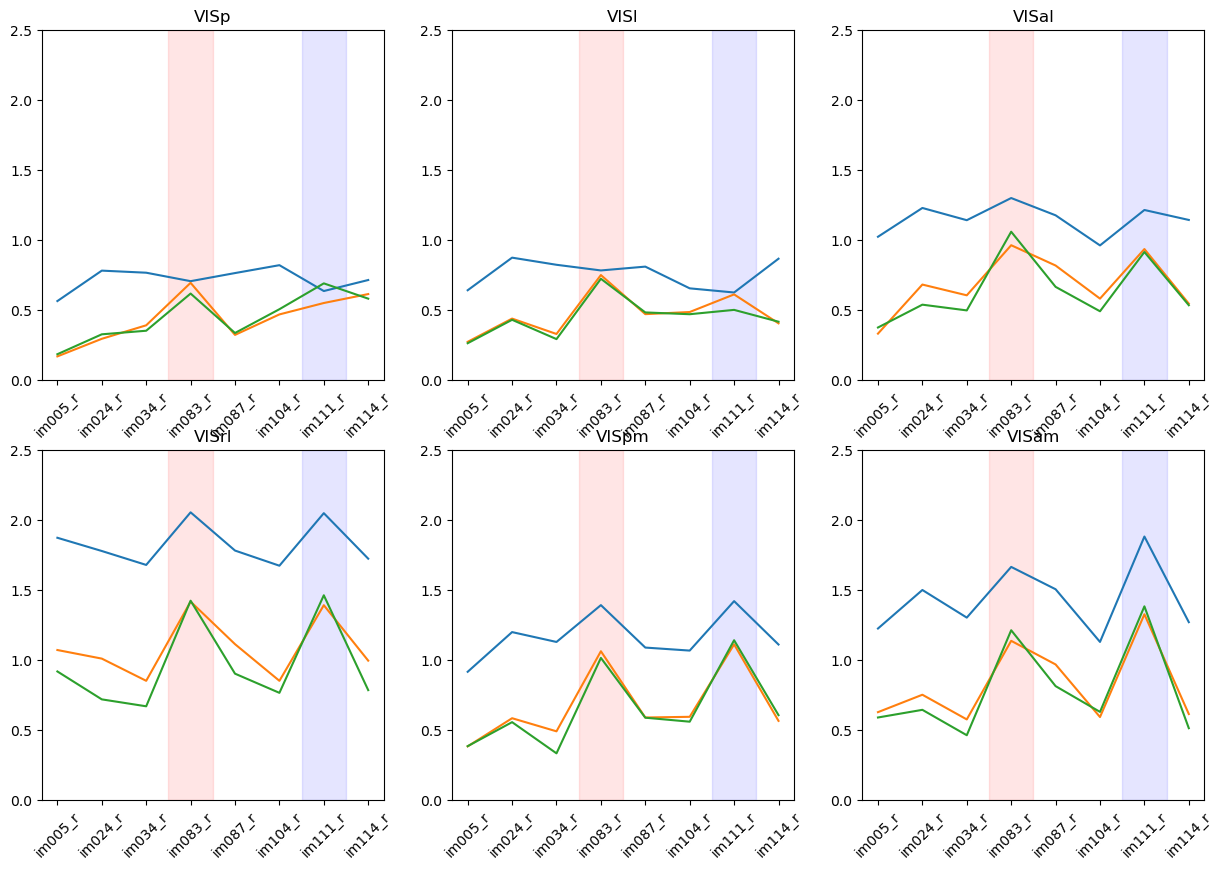

In [41]:
ids = g_g1h2_h2
u_entropy_total = np.zeros(8)
h_entropy_total = np.zeros(8)
m_entropy_total = np.zeros(8)
fig, axs = plt.subplots(2,3,figsize=(15,10))
for idx, area in enumerate(areas):
    counter = 0
    u_entropy_total = np.zeros(8)
    h_entropy_total = np.zeros(8)
    m_entropy_total = np.zeros(8)
    for i in ids:
        for iter in range(5):
            path = "C:/Users/jerry/Downloads/train_by_area_250/" + str(area) + "/" + str(i) + "_" + str(iter) + ".npz"
            try:
                a = np.load(path, allow_pickle=True)
            except:
                continue
            u = a['u'][0:-1]
            h = a['h']
            m = a['m']
            g = a['g']
            u_entropy_total += entropy(u+1e-10, axis=1,base=2)
            h_entropy_total += entropy(h+1e-10, axis=1,base=2)
            m_entropy_total += entropy(m+1e-10, axis=1,base=2)
            counter += 1
    u_entropy_total = u_entropy_total / counter
    h_entropy_total = h_entropy_total / counter
    m_entropy_total = m_entropy_total / counter
    axs[idx//3][idx%3].plot(u_entropy_total, label  = 'unchanged')
    axs[idx//3][idx%3].plot(h_entropy_total, label  = 'hit')
    axs[idx//3][idx%3].plot(m_entropy_total, label  = 'miss')
    axs[idx//3][idx%3].axvspan(2.5,3.5,alpha=0.1,color='red')
    axs[idx//3][idx%3].axvspan(5.5,6.5,alpha=0.1,color='blue')
    axs[idx//3][idx%3].set_title(area)
    axs[idx//3][idx%3].set_yticks(np.arange(0.,2.6,0.5));
    axs[idx//3][idx%3].set_xticks(ticks = np.arange(0,8), labels = imgs_h[:-2], rotation=45);

In [87]:
X,N = get_X(sp, spike_times, unit_idx, 250)

NameError: name 'unit_idx' is not defined